# Deep Hedging AI: Comparison to Black & Scholes

In this notebook we run Deep Hedging in a Black & Scholes world
_without statistical drift_. In this case we can compare hedging a vanilla call vs its perfect hedge.

### Proof that Deep Hedging should converge to the Black & Scholes price

We are using the notation from the mark down file https://github.com/hansbuehler/deephedging.
Let $Z_T$ be the claim in $T$. Assume that there are no trading cost and that the market is _complete_. This applies to Black & Scholes, and also to most other models typically used in quant finance.
In the limit of $dt\downarrow 0$ that menas there is a perfect replication strateg $\alpha^*$ such that
$$
    (*) \ \ \ \ Z_T \equiv z_0 + \sum_{t=0}^{T-1} \alpha_t^*(s_t)\ ( H_T - H_t)
$$
The constant $z_0$ is the risk-neutral price of $Z_T$.

Consider now our risk-adjusted return metric $U$ as used in Deep Hedging. We are trying to compute
$$
    \sup_a:\ U\left[\ Z_T + \sum_{t=0}^{T-1} a_t(s_t)\ ( H_T - H_t)\ \right]
$$
We now insert $(*)$ for $Z_T$. That gives
$$
    \sup_a:\ U\left[\ z_0 + \sum_{t=0}^{T-1} \alpha_t^*(s_t)\ ( H_T - H_t) + \sum_{t=0}^{T-1} a_t(s_t)\ ( H_T - H_t)\ \right]
$$
Because of _cash-invariance_ we can move $z_0$ out of $U$.
$$
(**) \ \ \ \    z_0 + \sup_a:\ U\left[\ \sum_{t=0}^{T-1} \left( \alpha_t^*(s_t) - a_t(s_t) \right)\ ( H_T - H_t) \ \right]
$$
In case that the underlying path generator is a risk-neutral measure we get $\mathrm{E}_t[ H_T - H_t ] = 0$ and therefore that $\mathrm{E}_t[ x_t(a_t) ( H_T - H_t)  ]=0$ for any possible strategy $x$.
Moreover, because $U$ has the property that $U(X) \leq E[X]$ we see that an optimal solutio for $(**)$ is achived in
$$
    a_t = -\alpha^*_t
$$
which means that the optimal solution to the Deep Hedging problem for _any_ monetary utility is the risk-neutral strategy.
We also note that the utility of $Z_T$ under the Deep Hedging is
$
z_0 + U(0) = z_0 
$
in other words it returns the risk-neutral price as well.

### Questions

* *Why are the hedges for vanilla options not limited by -1/+1:* the hedging signal from Deep Hedging is an interpolation. In the grapsh below we show both the hedge per one of the 10,000 path, and a binned interpolation. In order to increase precision, a bigger network needs to be trained. It is important to notice that the noise does not impede the quality of the hedge when measures via the utility $U$.
* *How does that compare to the results in the Deep Hedging paper:* in that paper we artificially restricted delta to -1/+1. This should have been noted in the model.

In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.11" "tensorflow_probability==0.19"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
my_path = None
if i!=-1:
    my_path = p[:i]
    import sys
    sys.path.append(my_path)
    print("SageMaker: added python path %s" % my_path)
else:
    print(sys.path)

SageMaker: added python path /home/ec2-user/SageMaker


In [2]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20       # 20 weekly steps
config.world.dt = 5./250.     # """
config.world.drift = 0.       # no drift
config.world.cost_s = 0.        # no cost
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 0.5
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = 2000
config.trainer.train.epochs = 20000
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

config_small_dt = config.copy()
config_small_dt.world.steps = 20*5  # 100 daily steps
config_small_dt.world.dt = 1./250.  # """

Deep Hedging AI says hello  ... Tensorflow version 2.11.0 running on 1 CPUs and 0 GPUs


2023-03-26 08:33:37.728951: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Deep Hedging in a Black \& Scholes World - Big Steps

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Initializing training at 2023-03-26 08:33:41: gym with 944 trainable weights compiled. Took 2s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/dff50b3c68cae2b16a88c8b6b638ae421e454c8587a0e349.pck'
Cache successfully loaded. Current epoch: 20000
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/dff50b3c68cae2b16a88c8b6b638a

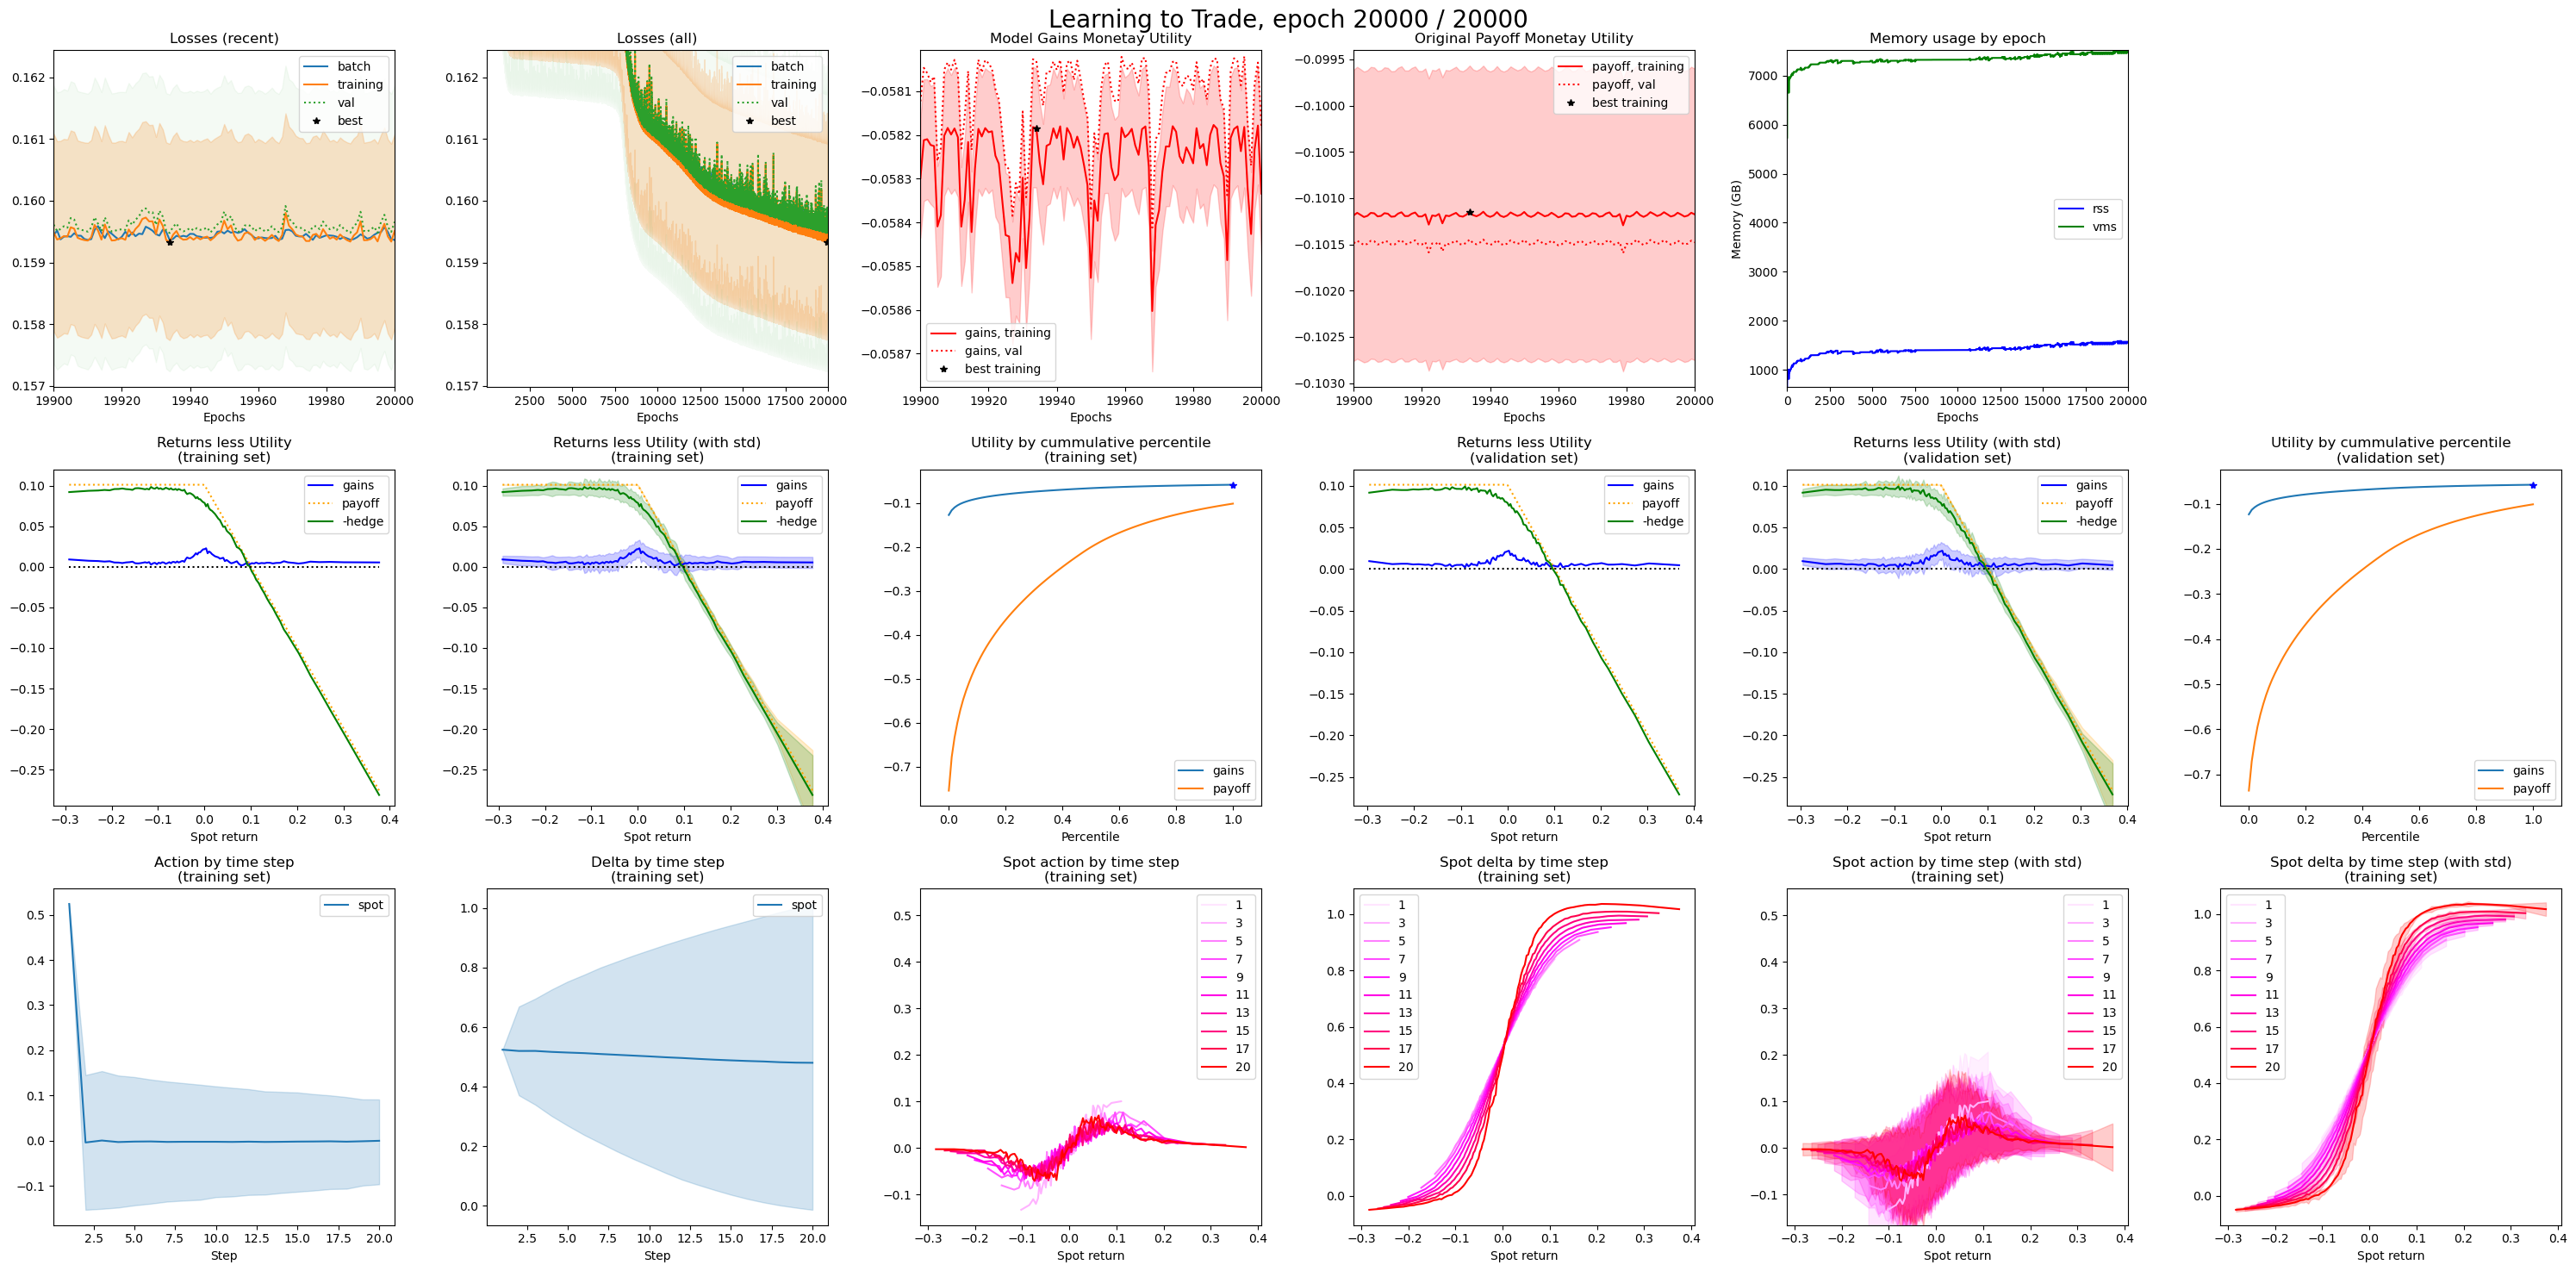

Training 20000/20000 epochs; 944 weights; 10000 samples; 5000 validation samples batch size 2000 | initial loss 0.202517 (0.00257571), training 0.15951 (0.0015695), best 0.159331 (0.00257571), batch 0.159362, val 0.159658 (0.00221444); best epoch 19934, last cached 20000 | memory used: rss 1574.07M, vms 7487.79M | time elapsed 2:54:44; time per epoch 0s; estimated time remaining 0s | current time: 2023-03-26 08:33:46                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 19934
 State of training until epoch 20000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/dff50b3c68cae2b16a88c8b6b638ae421e454c8587a0e349.pck
 Time: 2023-03-26 08:33:48
Training terminated. Total time taken 7s


In [3]:
display(Markdown("## Deep Hedging in a Black \& Scholes World - Big Steps"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()

Running strategies ...done
Running tensorflow to compute utility of BS strategy ...done; result -0.0505722
Rendering now. Stand by.


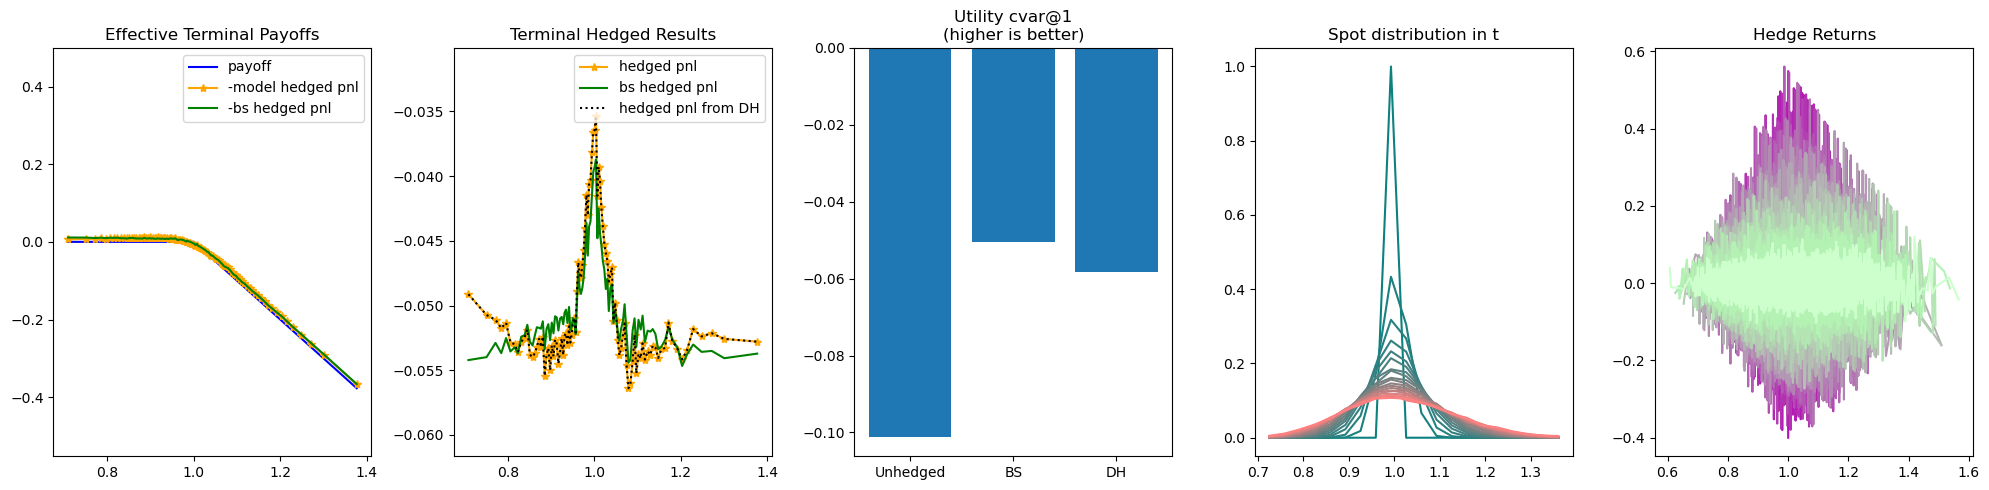

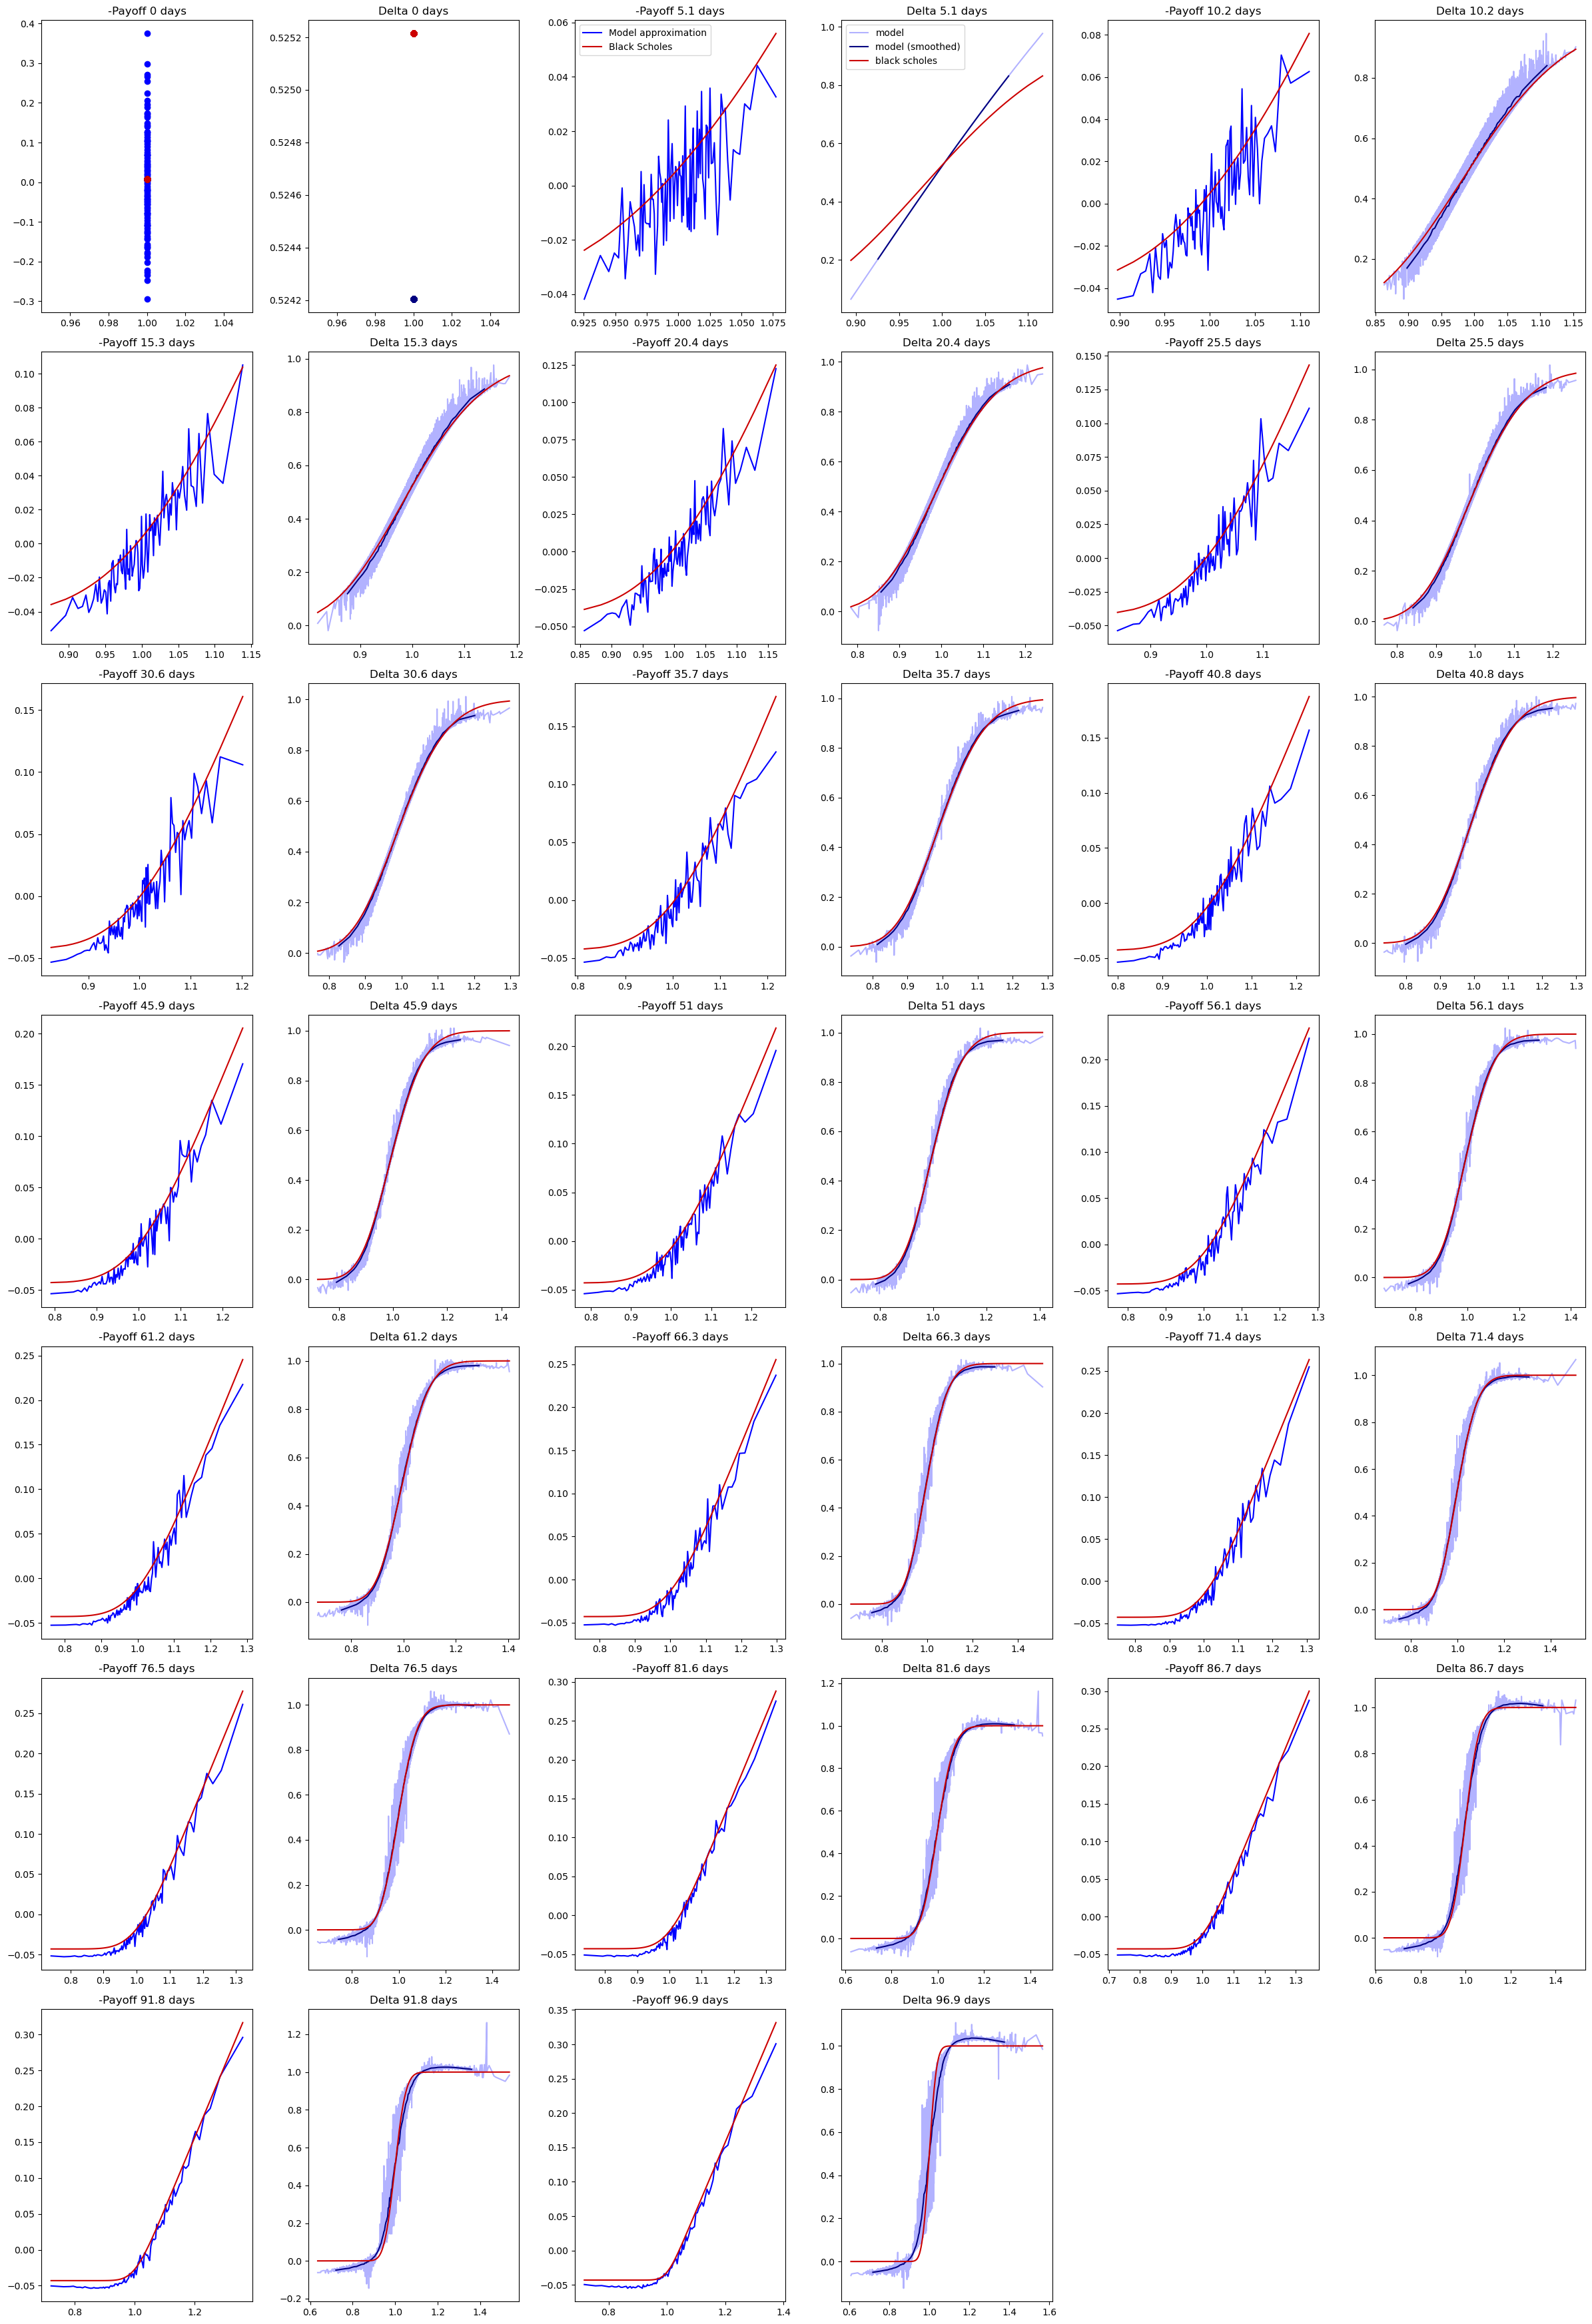

In [4]:
import deephedging.plot_bs_hedge as plot_bs_hedge
plot_bs_hedge.plot_blackscholes( world, gym, config )

## Deep Hedging in a Black \& Scholes World - Small Steps (this blew up before 26000)

Initializing training at 2023-03-26 08:33:59: gym with 944 trainable weights compiled. Took 1s
Agent is using 942 weights: 941 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/e19681b93330f97b8ce6fd91b75093c1d0e4071ebf43cf86.pck'
Cache successfully loaded. Current epoch: 20000
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/e19681b93330f97b8ce6fd91b7509

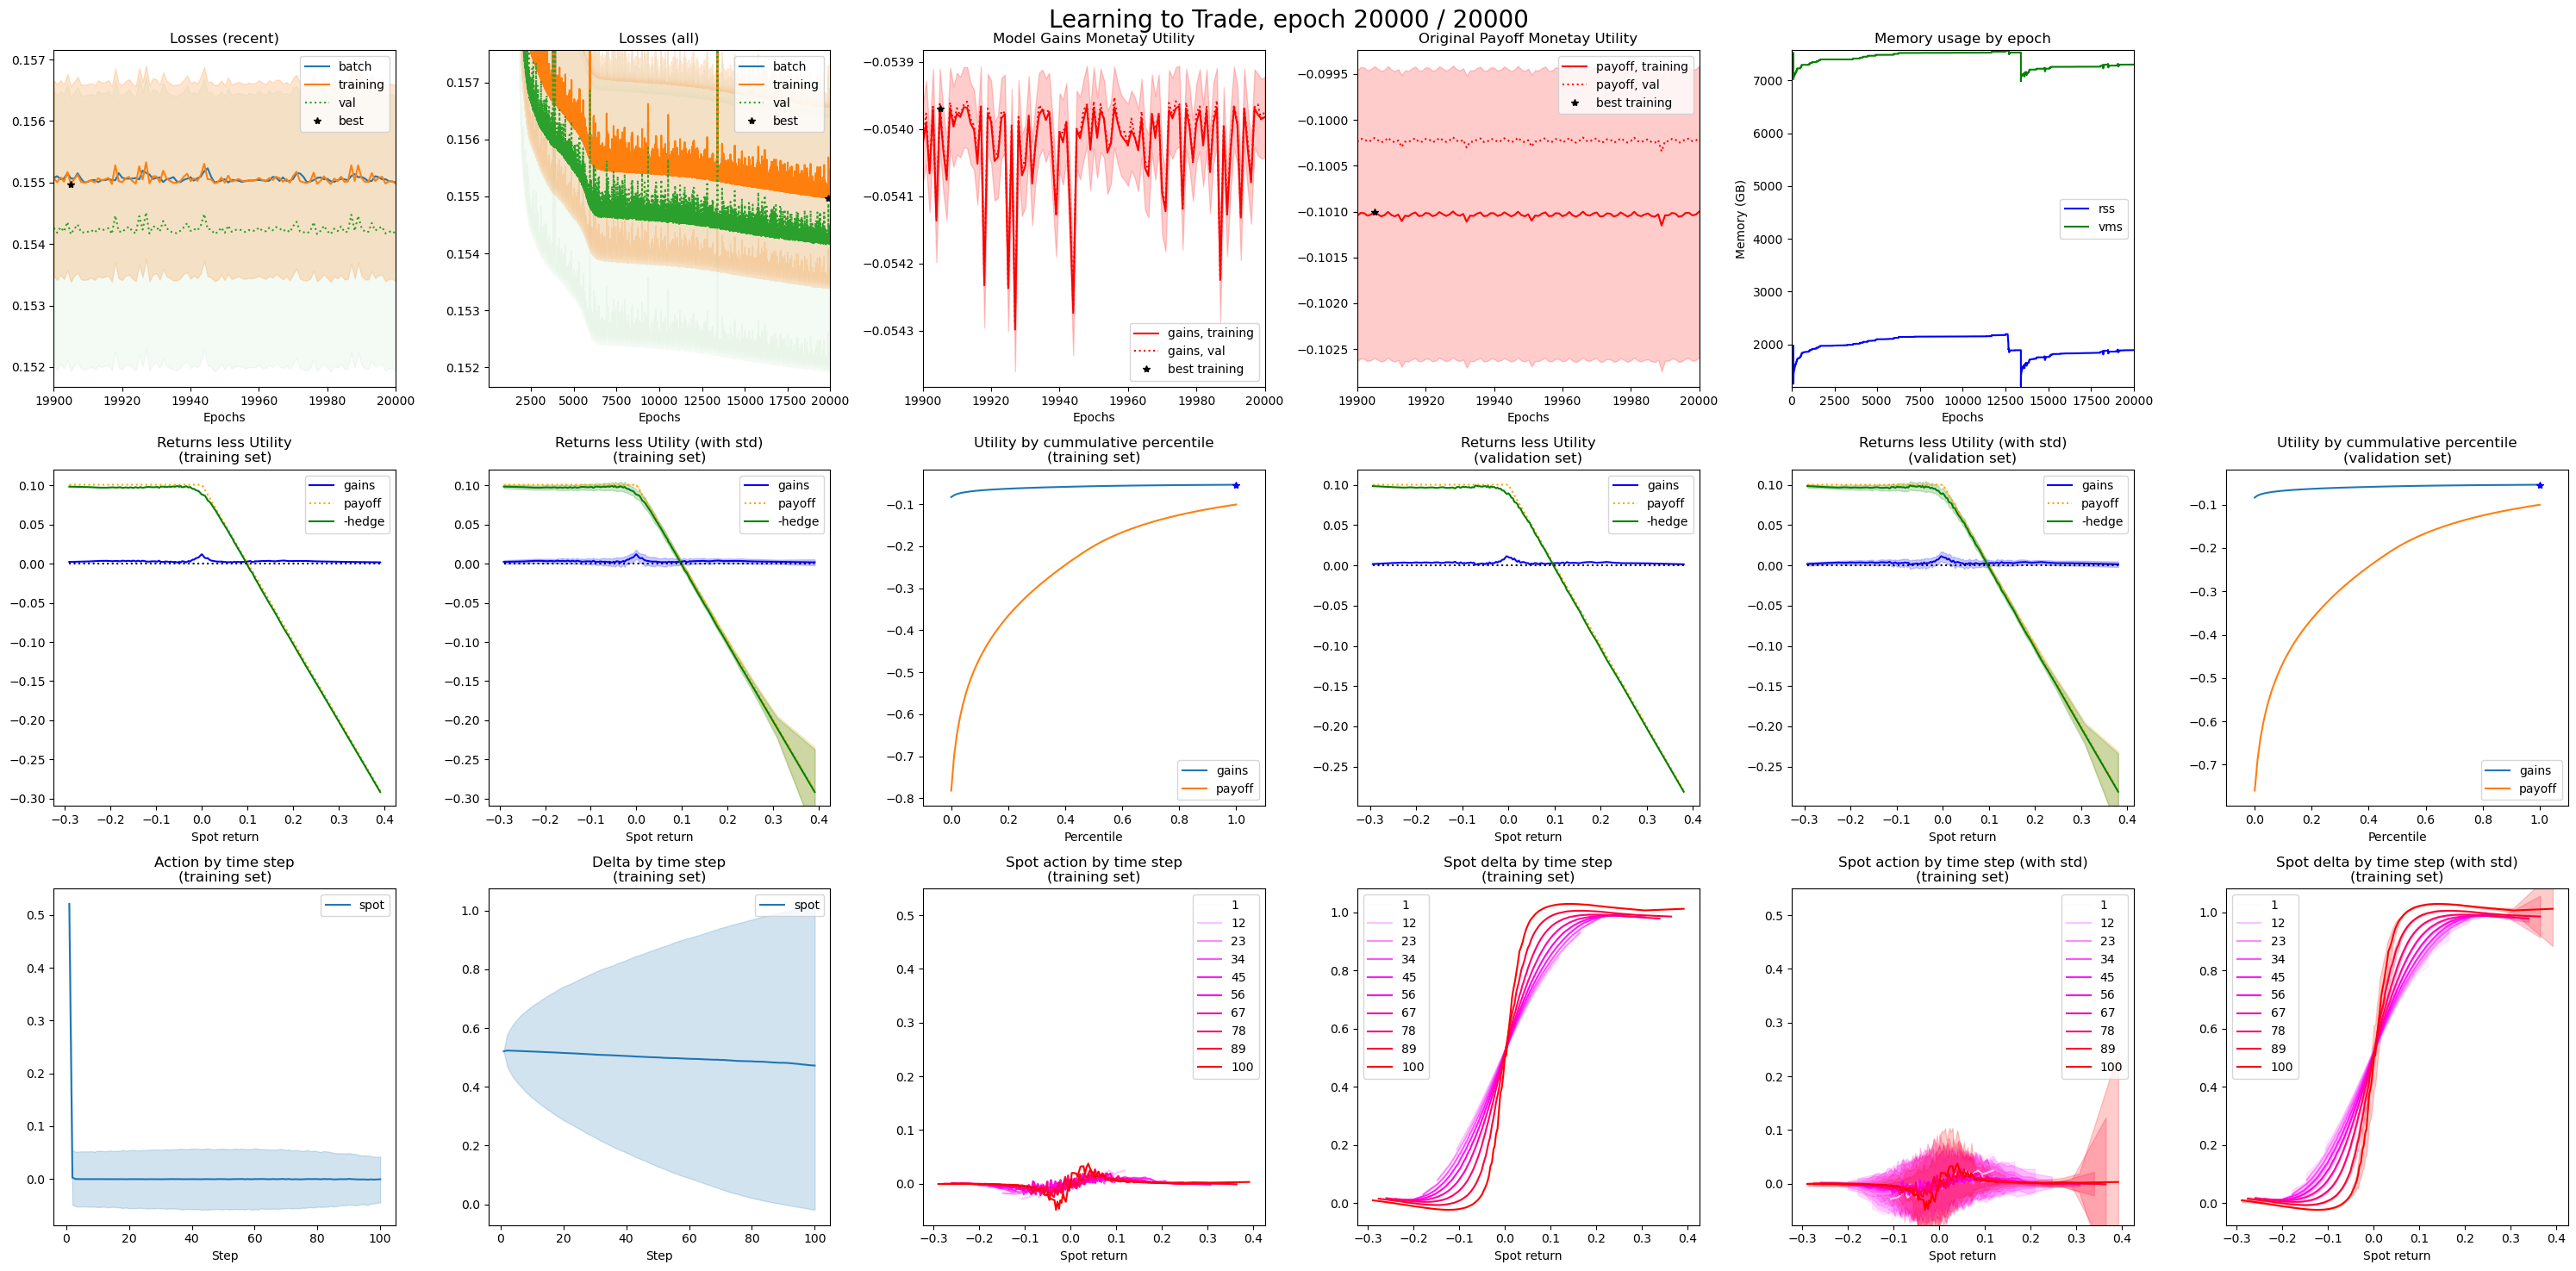

Training 20000/20000 epochs; 944 weights; 10000 samples; 5000 validation samples batch size 2000 | initial loss 2.96303 (0.0467212), training 0.154984 (0.00159272), best 0.154975 (0.0467212), batch 0.155001, val 0.154165 (0.00223553); best epoch 19905, last cached 20000 | memory used: rss 1892.11M, vms 7299.01M | time elapsed 10:13:44; time per epoch 1s; estimated time remaining 0s | current time: 2023-03-26 08:34:04                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 19905
 State of training until epoch 20000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/e19681b93330f97b8ce6fd91b75093c1d0e4071ebf43cf86.pck
 Time: 2023-03-26 08:34:06
Training terminated. Total time taken 7s


In [5]:
display(Markdown("## Deep Hedging in a Black \& Scholes World - Small Steps (this blew up before 26000)"))

config_small_dt.trainer.caching.mode = "on"

# create world
world      = SimpleWorld_Spot_ATM( config_small_dt.world )
val_world  = world.clone(samples=world.nSamples//2)

# create training environment
gym = VanillaDeepHedgingGym( config_small_dt.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config_small_dt.trainer )
config_small_dt.done()

Running strategies ...done
Running tensorflow to compute utility of BS strategy ...done; result -0.0504989
Rendering now. Stand by.


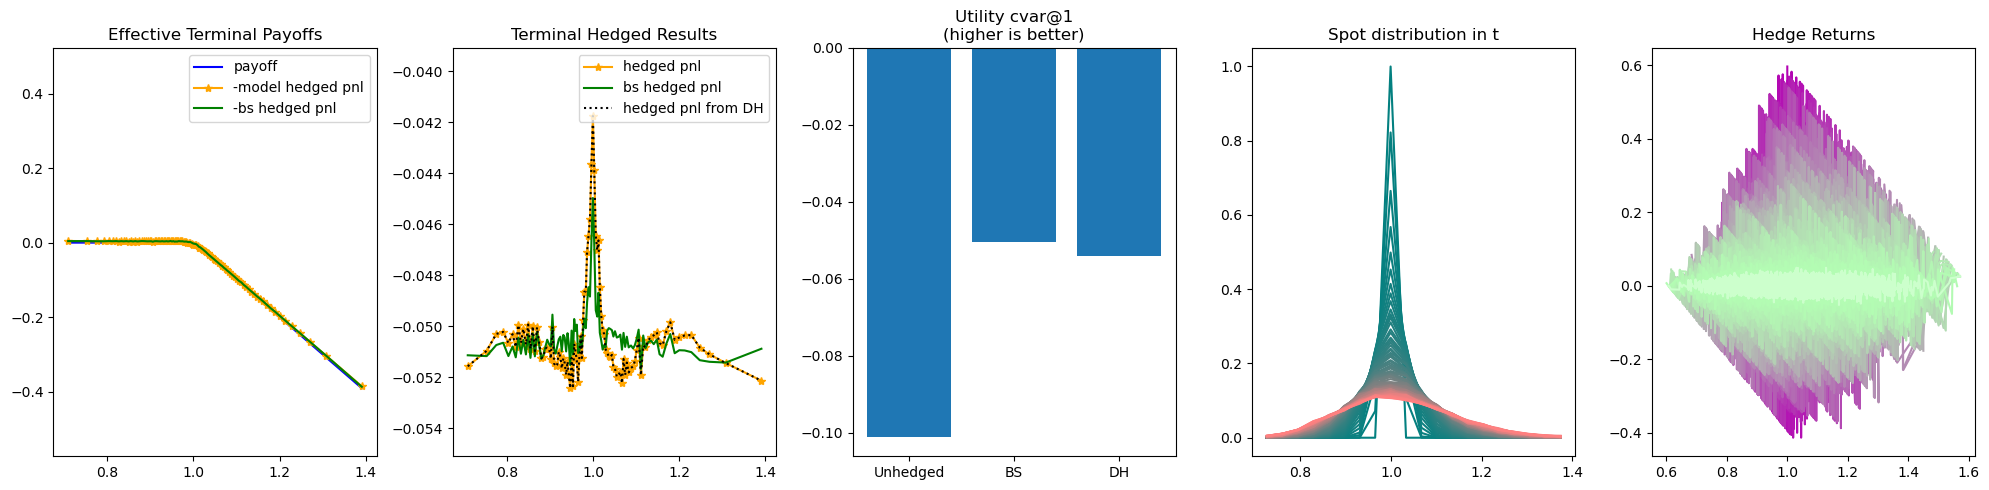

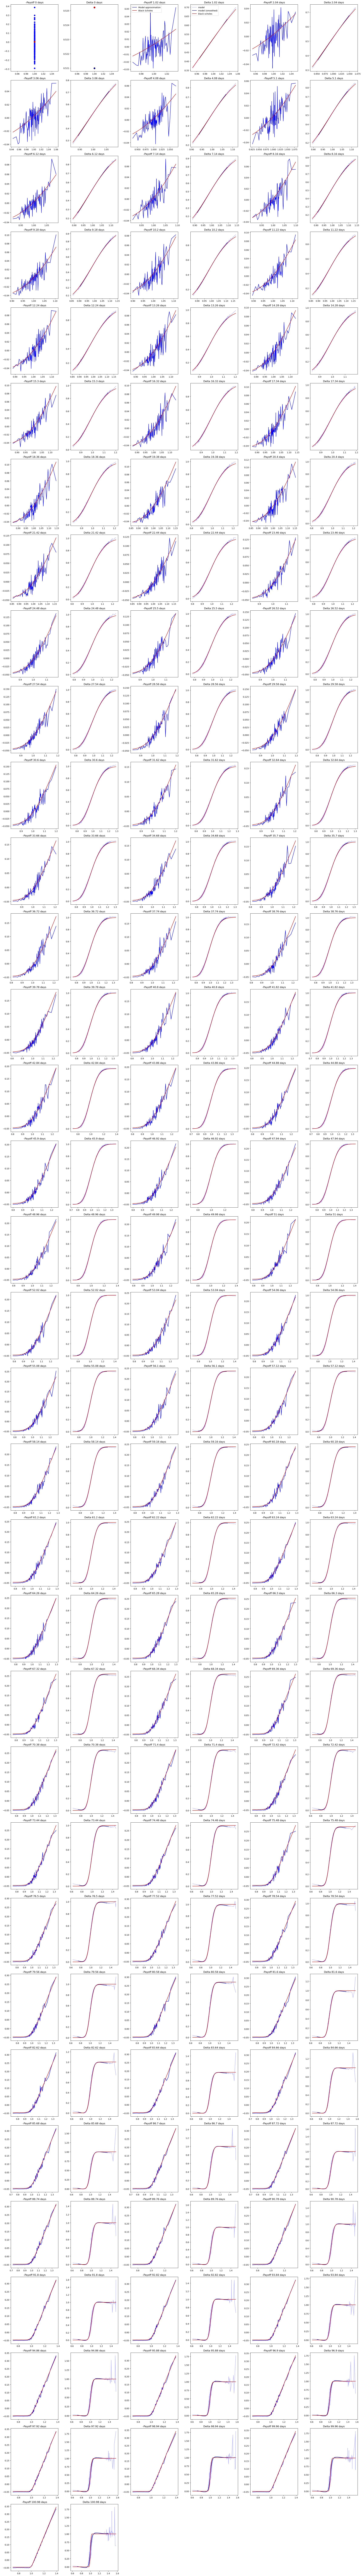

In [6]:
import deephedging.plot_bs_hedge as plot_bs_hedge
plot_bs_hedge.plot_blackscholes( world, gym, config_small_dt )